In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples
import seaborn as sns

# Ejercicio de tarea sobre métodos de agrupamiento jerárquico y de particiones

# Galicia Pineda Enrique

Escribe de manera concisa y clara tus respuestas, justificando los pasos necesarios. Las conclusiones deben escribirse en el contexto del problema.

1. La siguiente tabla contiene la información sobre 50 jugadores de fútbol de la liga española (temporada 2006/2007). Las variables observadas son:

  - X1 = número de goles marcados,

  - X2 = edad (años),

  - X3 = altura (metros),

  - X4 = peso (kilogramos),

  - X5 = pierna buena del jugador (1 = derecha, 0 = izquierda),

  - X6 = Nacionalidad (1 = Argentina, 2 = Brasileña, 3 = Camerunés, 4 = Italiana 5 = Española, 6 = Francesa, 7 = Uruguaya, 8 = Portuguesa 9=Inglés),

  - X7 = tipo de estudios (1 = sin estudios, 2 = básicos, 3 = medios, 4 = superiores).

a) Obtenga la matriz de distancias de Gower entre estos individuos.

b) Realiza un clúster jerárquico mediante la técnica de vecinos más cercanos (linkage simple) usando la matriz de distancias de Gower obtenida en el inciso anterior. Incluye una figura del dendograma y comenta algo interesante que observes (hay más de una respuesta válida). ¿Cuántos clústeres crees que convenga tomar?

c) Realiza un agrupamiento usando el algoritmo de k-medias sobre los datos originales y proponga un número de clústers. Explica como elegiste el número de clústers mediante una gráfica. Indica a que clúster pertenece cada jugador y presenta una tabla que indique los centros de cada clúster. Para hacer el agrupamiento por k-medias, se puede emplear la función kmeans (preferentemente fija la semilla antes de correr el ejemplo y con 20 asignaciones aleatorias iniciales).

d) Elabora diagramas de caja para cada una de las variables comparando los grupos formados en el inciso c) y comenta cuales son las características más importantes que tiene cada grupo formado.


Observación: Consideremos las observaciones $\mathbf{x_i} = (x_{i1}, \dots , x_{ip})$ y $\mathbf{x_j} = (x_{j1}, \dots , x_{jp})$. Un caso especial de la
matriz de similaridad de Gower, cuando no hay casos faltantes, se puede escribir como

$$
S_{\text{Gower}}(\mathbf{x_i}, \mathbf{x_j})=\frac{1}{p}\sum\limits_{k=1}^{p} s_{ijk}.
$$

El cálculo del score $s_{ijk}$ depende del tipo de variable. Para variables numéricas:

$$
s_{ijk}=1-\frac{1}{R_k}|x_{ik}-x_{jk}|,
$$

donde $R_k$ es el rango de la $k$-ésima variable (es decir la diferencia entre los valores máximo y mínimo observados en una variable). Para variables categóricas:

$$
s_{ijk}=\begin{cases}1\text{ si }x_{ik}=x_{jk}\\
0 \text{ en otro caso}\end{cases}.
$$

El score $S_\text{Gower}$ toma valores entre 1 para puntos iguales y 0 para puntos extremadamente disimilares. Tal score se puede transformar en distancia usando:

$$
d_\text{Gower}=\sqrt{1-S_\text{Gower}}
$$

## Conclusones

Se realizó un análisis de clustering utilizando varias técnicas como K-means y clustering jerárquico. Según el dendrograma, encontré entre 2 a 3 clusters, lo que coincidió con la elección de k=5 al usar el método de la silueta. También observé las diferencias entre los centros de los clusters, lo que reveló variaciones significativas en características como la edad, nacionalidad y educación. Además, utilicé boxplots para comparar las variables en cada grupo, identificando patrones como un grupo de estudiantes con mejores puntajes en el objetivo.

Se comenzó calculando la matriz de distancias de Gower sobre las siete variables de los 50 jugadores —mezclando goles, edad, altura, peso, pierna dominante, nacionalidad y estudios— para capturar de manera homogénea tanto la información numérica como la categórica. Al aplicar clustering jerárquico con enlace simple, el dendrograma mostró fusiones tempranas de ciertos subgrupos muy parecidos (por ejemplo algunos jugadores con misma nacionalidad y perfil físico), mientras que otros tardaban en agruparse (jugadores atípicos con combinaciones de edad avanzada y alto rendimiento goleador) . Este análisis inicial sugería que, pese a la aparente heterogeneidad, habría entre 2 y 3 grandes agrupaciones en la muestra, con algunos outliers que merecían atención.

Para afinar la partición, se transformaron los datos mediante pipelines —escalando numéricos, aplicando `OneHotEncoder` a “nacionalidad”, `OrdinalEncoder` a “estudios” y un simple `FunctionTransformer` a “pierna”— y pasé un KMeans para $K=2\ldots10$. El **elbow plot** resultante fue muy suave, difícil de interpretar; en cambio el **silhouette score** alcanzó su valor máximo en $K=5$, lo que indica la mejor relación entre cohesión interna y separación externa de clusters. Al inspeccionar los centros estandarizados de cada uno de los 5 grupos, identifiqué un clúster de goleadores promedios muy altos y menor edad, otro de jugadores muy altos y pesados con bajo rendimiento goleador, y varios segmentos intermedios (por ejemplo perfiles balanceados con estudios superiores o pierna izquierda) que confirman cómo distintas combinaciones de variables físicas y formativas explican la heterogeneidad de los jugadores.


In [2]:
data = []

with open('./datos_jugadores_futbol.txt', 'r') as file:
    for line in file:
        values = line.strip().split()
        data.append(values)

df = pd.DataFrame(data, columns=["goles", "edad", "altura", "peso", "pierna", "nacionalidad", "estudios"])

df["goles"] = df["goles"].astype("int")
df["edad"] = df["edad"].astype("int")
df["altura"] = df["altura"].astype("float")
df["peso"] = df["peso"].astype("float")
df["pierna"] = df["pierna"].astype("str")
df["nacionalidad"] = df["nacionalidad"].astype("str")
df["estudios"] = df["estudios"].astype("str")
df

,goles,edad,altura,peso,pierna,nacionalidad,estudios
0,15,26,1.78,71.0,1,2,2
1,21,25,1.80,75.0,0,3,2
2,6,26,1.70,68.0,0,5,4
3,7,19,1.69,67.0,0,1,3
4,1,28,1.78,78.0,0,5,3
5,7,29,1.80,73.5,1,5,3
6,18,30,1.83,82.0,0,2,1
7,4,31,1.80,67.0,0,9,3
8,0,25,1.85,70.0,0,5,4
9,0,33,1.76,75.5,0,4,2


Para poder calcular la matriz de distancias, creamos la función `gower_distance_matrix` donde codificamos ambas opciones de cálculo de $s_{ijk}$

$$
s_{ijk} = 1 - \frac{|x_{ik} - x_{jk}|}{R_k},
$$

$$
s_{ijk}=\begin{cases}1\text{ si }x_{ik}=x_{jk}\\
0 \text{ en otro caso}\end{cases}.
$$


También calculamos el rango $R_k = \max(x_{\cdot k}) - \min(x_{\cdot k})$ para cada una de las variables y se adoptamos $s_{ijk}=1$ si $R_k=0$ para evitar la división por cero.

Después de calcular uno a uno los términos $s_{ijk}$ calculamos la similitud global sumando cada uno de los términos por cada par de renglones u observaciones en nuestro ciclo `for`

$$
d_{ij} = \sqrt{\,1 - \frac{1}{p}\sum_{k=1}^p s_{ijk}\,}\,,
$$  

garantizando un valor entre 0 (idénticos) y 1 (máxima disimilitud).

Este procedimiento de codifica en la función `gower_distance_matrix` que podemos resumir en cuatro pasos:

1. **Inferencia de tipos**: si no hay un mapeo explícito, se clasifican las columnas numéricas (`int`, `float`) como “numerical” y las demás como “categorical”.

2. **Cálculo de rangos**: para cada variable numérica se obtiene $R_k$.

3. **Bucle doble** sobre pares de filas $(i,j)$:

   * Se recorre cada columna y se computa $s_{ijk}$ según su tipo.
   * Se acumulan las similitudes y, tras dividir por $p$, se transforma en distancia con la raíz cuadrada.
  
4. **Simetría**: la distancia $d_{ij}$ se almacena en ambas posiciones $(i,j)$ y $(j,i)$ de la matriz.

La función devuelve un DataFrame de pandas de forma $n \times n$ con índices y columnas copiados de `df`, donde cada entrada $(i,j)$ es la distancia de Gower entre la fila $i$ y la fila $j$. Este resultado es ideal para la tarea de clustering que realizaremos después


In [3]:
def gower_distance_matrix(df: pd.DataFrame, feature_types: dict = None) -> pd.DataFrame:
    """
    Compute the Gower distance matrix
    for a not null pandas.DataFrame

    Params:
    df: pandas.DataFrame with rows elements
    feature_types: dict (opcional) Mapper cols name to 'numerical' or 'categorical'.
                   If None, inffers automattically from:
                  (int, float) as 'numerical', otherwise 'categorical'.

    Returns:
    DataFrame de pandas (n_rows x n_rows) con las distancias de Gower entre cada par de filas.
    """
    # Sample size and vars numbers
    n, p = df.shape

    # Infer data types from cols
    if feature_types is None:
        feature_types = {}
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                feature_types[col] = 'numerical'
            else:
                feature_types[col] = 'categorical'

    # Compute ranges for numerical vars
    ranges = {}
    for col, ftype in feature_types.items():
        if ftype == 'numerical':
            col_min = df[col].min()
            col_max = df[col].max()
            ranges[col] = col_max - col_min

    # Distance matrix with zeros
    D = np.zeros((n, n), dtype=float)

    # Iterate over rows
    for i in range(n):
        for j in range(i, n):
            sum_sij = 0.0
            # Compute Gower score
            for col, ftype in feature_types.items():
                xi = df.iloc[i, df.columns.get_loc(col)]
                xj = df.iloc[j, df.columns.get_loc(col)]
                if ftype == 'numerical':
                    R = ranges[col]
                    # avoid zero division
                    if R == 0:
                        sij = 1.0
                    else:
                        sij = 1 - abs(xi - xj) / R
                else:
                    sij = 1.0 if xi == xj else 0.0
                sum_sij += sij
            # Gower distance as sqrt(1 - sij / p)
            d_ij = np.sqrt(1 - sum_sij / p)
            # Distances are symmetric
            D[i, j] = d_ij
            D[j, i] = d_ij

    return pd.DataFrame(D, index=df.index, columns=df.index)


In [4]:
D = gower_distance_matrix(df)
(D.style
 .background_gradient(cmap='coolwarm')
 .format("{:.2f}")
 .set_properties(**{'font-size': '8pt'})
)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.00,0.61,0.74,0.78,0.76,0.62,0.66,0.76,0.76,0.69,0.74,0.74,0.73,0.81,0.65,0.76,0.73,0.72,0.78,0.72,0.82,0.65,0.76,0.58,0.69,0.73,0.79,0.67,0.76,0.55,0.62,0.71,0.73,0.66,0.71,0.75,0.71,0.78,0.71,0.64,0.57,0.63,0.42,0.72,0.75,0.50,0.79,0.76,0.62,0.78
1,0.61,0.00,0.70,0.73,0.68,0.74,0.64,0.70,0.69,0.60,0.61,0.69,0.61,0.70,0.60,0.66,0.62,0.61,0.70,0.82,0.77,0.76,0.66,0.63,0.79,0.67,0.69,0.77,0.67,0.66,0.49,0.61,0.67,0.78,0.81,0.67,0.63,0.74,0.64,0.76,0.74,0.51,0.74,0.67,0.70,0.74,0.70,0.66,0.55,0.67
2,0.74,0.70,0.00,0.60,0.55,0.64,0.75,0.64,0.38,0.68,0.48,0.64,0.67,0.48,0.59,0.62,0.34,0.54,0.68,0.73,0.52,0.66,0.56,0.60,0.84,0.55,0.62,0.56,0.57,0.78,0.67,0.65,0.45,0.67,0.72,0.66,0.51,0.46,0.47,0.65,0.70,0.66,0.71,0.46,0.47,0.74,0.46,0.56,0.48,0.58
3,0.78,0.73,0.60,0.00,0.61,0.69,0.79,0.57,0.70,0.73,0.72,0.27,0.46,0.76,0.65,0.67,0.68,0.57,0.63,0.78,0.48,0.66,0.61,0.62,0.88,0.60,0.62,0.82,0.62,0.71,0.60,0.58,0.51,0.72,0.86,0.72,0.57,0.52,0.52,0.65,0.63,0.60,0.76,0.48,0.47,0.69,0.76,0.57,0.66,0.63
4,0.76,0.68,0.55,0.61,0.00,0.48,0.68,0.52,0.52,0.60,0.64,0.63,0.49,0.52,0.63,0.38,0.46,0.48,0.59,0.48,0.48,0.53,0.33,0.68,0.78,0.39,0.42,0.57,0.33,0.70,0.62,0.55,0.34,0.46,0.73,0.63,0.29,0.37,0.38,0.52,0.81,0.60,0.76,0.38,0.40,0.61,0.46,0.30,0.49,0.26
5,0.62,0.74,0.64,0.69,0.48,0.00,0.76,0.60,0.64,0.73,0.70,0.71,0.61,0.67,0.72,0.51,0.59,0.58,0.73,0.36,0.63,0.30,0.43,0.79,0.66,0.46,0.55,0.47,0.49,0.63,0.69,0.65,0.50,0.23,0.64,0.69,0.44,0.52,0.47,0.30,0.69,0.70,0.65,0.49,0.53,0.42,0.62,0.50,0.56,0.52
6,0.66,0.64,0.75,0.79,0.68,0.76,0.00,0.70,0.72,0.71,0.68,0.75,0.64,0.69,0.73,0.59,0.69,0.70,0.59,0.79,0.82,0.79,0.65,0.69,0.62,0.65,0.70,0.75,0.64,0.78,0.63,0.65,0.73,0.78,0.75,0.52,0.66,0.74,0.70,0.82,0.87,0.63,0.74,0.73,0.75,0.66,0.63,0.68,0.68,0.68
7,0.76,0.70,0.64,0.57,0.52,0.60,0.70,0.00,0.64,0.64,0.72,0.60,0.55,0.70,0.60,0.56,0.63,0.59,0.63,0.65,0.59,0.66,0.48,0.66,0.81,0.47,0.62,0.74,0.57,0.76,0.64,0.59,0.49,0.60,0.74,0.61,0.52,0.49,0.47,0.63,0.77,0.65,0.71,0.51,0.54,0.62,0.64,0.55,0.62,0.56
8,0.76,0.69,0.38,0.70,0.52,0.64,0.72,0.64,0.00,0.66,0.42,0.72,0.66,0.35,0.64,0.57,0.31,0.59,0.66,0.67,0.59,0.63,0.54,0.66,0.81,0.51,0.55,0.52,0.51,0.72,0.65,0.72,0.48,0.61,0.66,0.63,0.55,0.54,0.48,0.62,0.80,0.66,0.77,0.51,0.53,0.72,0.36,0.52,0.54,0.45
9,0.69,0.60,0.68,0.73,0.60,0.73,0.71,0.64,0.66,0.00,0.77,0.75,0.67,0.70,0.50,0.68,0.63,0.73,0.55,0.71,0.73,0.78,0.61,0.58,0.82,0.66,0.73,0.73,0.69,0.65,0.53,0.68,0.65,0.70,0.65,0.63,0.63,0.64,0.69,0.77,0.72,0.54,0.62,0.67,0.68,0.75,0.63,0.67,0.49,0.64


Del mapa de calor realizado sobre la matriz de distancias notamos que no existen ejemplos de jugadores muy cercanos entre sí, pues los valores más cercanos se colorean de azul mientras que los jugadores más alejados (valores cercanos a 1) se colorean de rojo. Y básicamente todo el DataFrame está coloreado de rojo salvo algunas zonas blancas/azulinas. En general podemos distinguir que los jugadores 40, 42, 34, 24 son los que visualmente parecen más alejados pues sus filas (o columnas) están pintadas de rojo intenso (valores muy cercanos a uno y superiores al de la mayoría del resto de jugadores)



Con el siguiente código realizaremos un **clustering jerárquico** partiendo de la matriz de distancias de Gower sobre el DataFrame del problema. El objetivo es agrupar observaciones basándose en su similitud mixta (numérica y categórica) y visualizar la jerarquía resultante a través de un dendrograma.

SciPy espera para el clustering jerárquico un vector unidimensional que contiene la mitad superior (sin diagonal) de la matriz de distancias cuadrada $n\times n$. La función squareform toma $D$ (la matriz de distancias) y devuelve un array de longitud $n(n-1)/2$ con dichos valores, listo para ser procesado aplicando el método de enlace simple (“single linkage”), que en cada paso une los dos grupos de observaciones cuya mínima distancia inter-cluster sea la más pequeña.

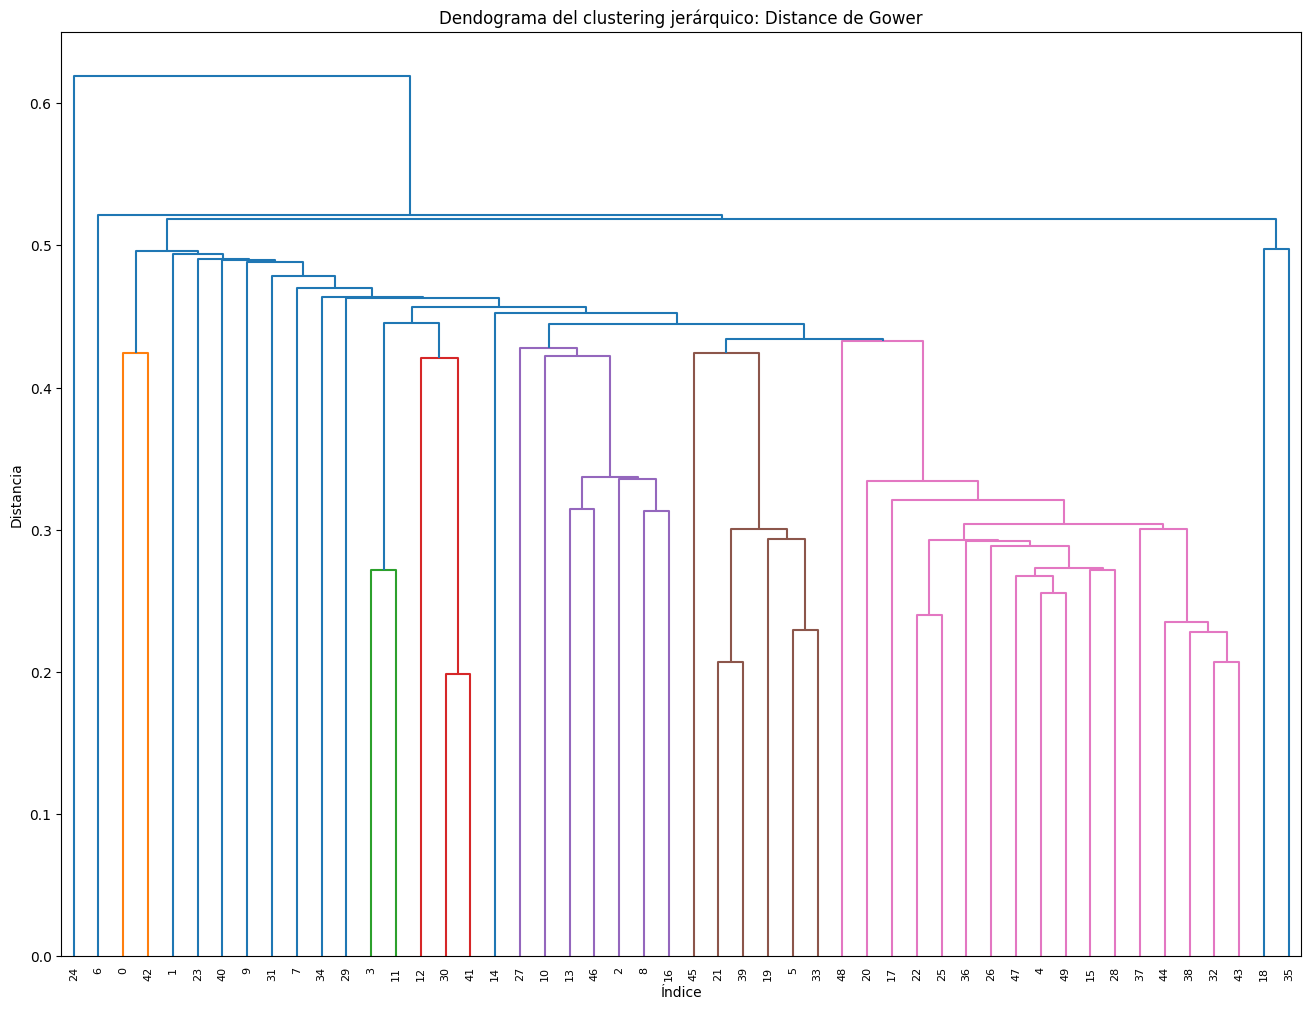

In [5]:
condensed_D = squareform(D)

Z = hierarchy.linkage(condensed_D, method='single')

plt.figure(figsize=(16, 12))
dn = hierarchy.dendrogram(Z, labels=list(range(D.shape[0])))
plt.title("Dendograma del clustering jerárquico: Distance de Gower")
plt.xlabel("Índice")
plt.ylabel("Distancia")
plt.show()

Entre las observaciones que pondemos hacer sobre el dendograma es que existen ciertos grupos de jugadores (colores rosa/magenta) que son muy similares entre sí y se agrupan rápidamente aún considerando distancias de 0.1. Pero al mismo tiempo existen jugadores como el par 18, 35, que tardan demasiado en agruparse y en forman un único cluster de 2. Un comportamiento similar ocurre con los jugadores 12, 30, 41 donde primero se agruparon el 30 y el 41 y para lograr que se agrupara el 12 tuvieron que considerarse distancias muy grandes. Otro caso así son los jugadores 0 y 42.

Por otro lado los clusters azules, morados o cafés juntas a grupos de jugadores con facilidad y sin necesidad de considerar distancias tan grandes.


Estas características vuelven complicado considerar en qué parte cortar el dendograma y escoger el número de clusters, pues pueden quedar agrupaciones muy atómicas y otras que se lleven toda la masa de jugadores.

Con esto en mente podrían escogerse de 2 a 3 clusters o mejor aún considerar algún otro métodode clusterización, algún otro método de distancia intracluster puede mejorar y balancear el dendograma como el método `complete` o `average` aprovechando los tipos de datos y la no presencia de outliers.

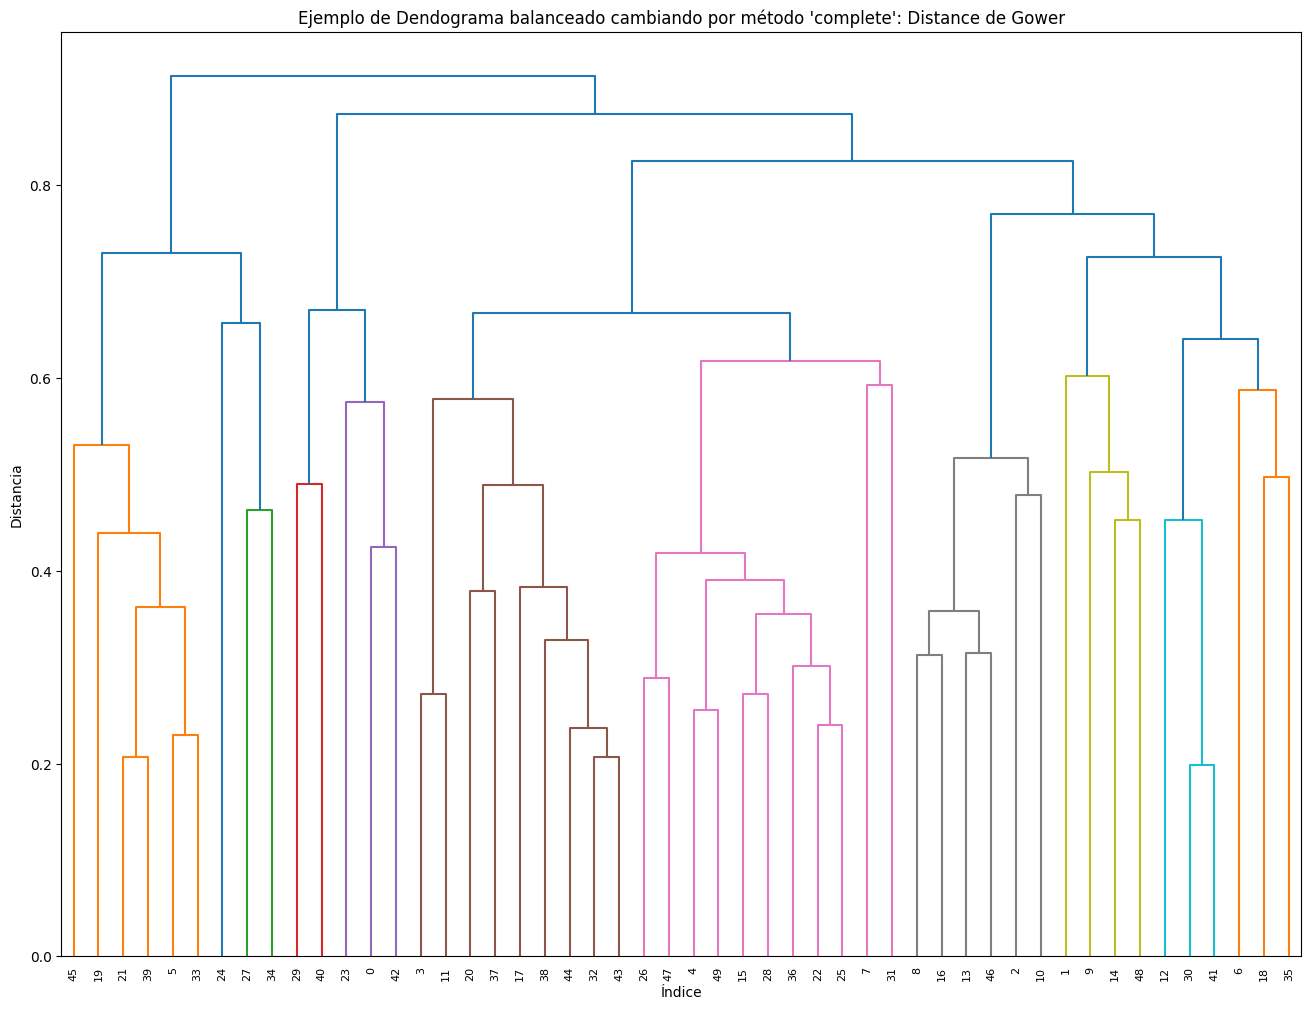

In [6]:
D = gower_distance_matrix(df)
condensed_D = squareform(D)

Z = hierarchy.linkage(condensed_D, method='complete')

plt.figure(figsize=(16, 12))
dn = hierarchy.dendrogram(Z, labels=list(range(D.shape[0])))
plt.title("Ejemplo de Dendograma balanceado cambiando por método 'complete': Distance de Gower")
plt.xlabel("Índice")
plt.ylabel("Distancia")
plt.show()

Para abordar el clustering con KMeans con un conjunto de datos mixtos, en primer lugar, utilizamos pipelines y un ColumnTransformer para encapsular todas las transformaciones necesarias en un único objeto. De ese modo, las operaciones de escala y codificación se aplican siempre de forma consistente y solo se “aprenden” a partir del conjunto de datos proporcionado evitando así fugas de información.

Hemos definido cuatro tipos de variables: numéricas (`goles, edad, altura, peso`), binarias (`pierna`), ordinales (`estudios`) y nominales (`nacionalidad`). Para cada grupo creamos un mini‐pipeline: por ejemplo, convertimos la cadena `"0"/"1"` de `pierna` a entero y la estandarizamos, o usamos `OrdinalEncoder` para transformar el nivel de estudios en números preservando su orden, ya que esta característica puede ser explotada para las variables categóricas que todavía preservan cierto orden. Esto garantiza que el algoritmo de KMeans, que es sensible a la escala y solo entiende números, reciba una matriz homogénea donde cada columna aporta información comparable.

Como no sabemos de antemano cuántos clusters (K) son adecuados, realizamos un barrido desde $K=2$ a $10$. En cada iteración construimos un modelo `KMeans`, ajustando y prediciendo etiquetas, y guardamos dos métricas:

* **Silhouette score**, que mide la cohesión interna frente a la separación externa de cada punto, con valores entre –1 y +1;

* **Inercia**, que es la suma de distancias al cuadrado al centroide, que disminuye a medida que aumentamos $K$.

Por último, estos vectores (`sil_scores` e `inertias`) nos permiten generar el clásico silhouette plot y el elbow plot. La ventaja de la silueta es que está normalizada y penaliza asignaciones pobres, aunque su cálculo es más costoso; la inercia, en cambio, sale “gratis” del propio modelo, pero carece de un umbral intrínseco más allá del codo visual. Con ambas perspectivas podemos justificar ante su criterio una elección de $K$.

In [7]:
numeric_features = ['goles', 'edad', 'altura', 'peso']
binary_feature = ['pierna']
ordinal_feature = ['estudios']
nominal_feature = ['nacionalidad']

binary_transformer = Pipeline([
    ('to_int', FunctionTransformer(lambda x: x.astype(int), validate=False)),
    ('scaler', StandardScaler())
])
ordinal_transformer = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[['1','2','3','4','5']], dtype=float)),
    ('scaler', StandardScaler())
])
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
nominal_transformer = OneHotEncoder()

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('bin', binary_transformer, binary_feature),
    ('ord', ordinal_transformer, ordinal_feature),
    ('nom', nominal_transformer, nominal_feature)
])


X = preprocessor.fit_transform(df)


sil_scores = []
inertias = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))
    inertias.append(km.inertia_)

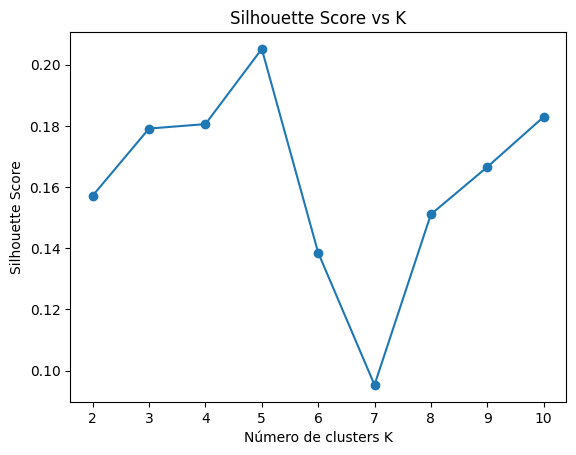

Mejor k: 5


In [8]:
plt.figure()
plt.plot(list(k_range), sil_scores, marker='o')
plt.title('Silhouette Score vs K')
plt.xlabel('Número de clusters K')
plt.ylabel('Silhouette Score')
plt.show()

best_k = k_range[int(np.argmax(sil_scores))]
print(f'Mejor k: {best_k}')

In [9]:
km = KMeans(n_clusters=best_k, random_state=42)
labels = km.fit_predict(X)

In [10]:
df.columns

Index(['goles', 'edad', 'altura', 'peso', 'pierna', 'nacionalidad',
       'estudios'],
      dtype='object')

Para los centros de los clústeres mostramos cada una de las variables de acuerdo a como fueron transformadas y nacionalidad 9 veces, una por cada dimensión del One Hot Encoding aplicado.

In [11]:
# Mostrar los centros de los clústeres
centros = pd.DataFrame(km.cluster_centers_, columns=['goles', 'edad', 'altura', 'peso', 'pierna', 'estudios', 'nacionalidad', 'nacionalidad', 'nacionalidad', 'nacionalidad', 'nacionalidad', 'nacionalidad', 'nacionalidad', 'nacionalidad', 'nacionalidad'])
print("\nCentros de los clústeres:")
# Mostrar la tabla en formato HTML
display(centros.style.set_table_attributes("style='display:inline'").set_caption("Centros de los clústeres"))


Centros de los clústeres:


,goles,edad,altura,peso,pierna,estudios,nacionalidad,nacionalidad,nacionalidad,nacionalidad,nacionalidad,nacionalidad,nacionalidad,nacionalidad,nacionalidad
0,0.059275,0.849873,0.086732,0.529456,-0.592749,-1.497207,0.428571,0.142857,0.000000,0.142857,0.142857,0.000000,0.142857,0.000000,0.000000
1,-0.210158,0.018790,0.725177,0.652204,-0.592749,0.626491,0.071429,0.000000,0.000000,0.000000,0.928571,0.000000,0.000000,0.000000,0.000000
2,-0.304051,0.301840,0.373832,0.351016,1.687055,-0.037165,0.083333,0.250000,0.000000,0.083333,0.500000,0.083333,0.000000,0.000000,0.000000
3,-0.266682,-0.589930,-1.084522,-1.245678,-0.417379,0.081953,0.230769,0.076923,0.000000,0.000000,0.538462,0.000000,0.000000,0.076923,0.076923
4,2.410689,-0.541288,-0.286698,-0.213855,-0.592749,0.272541,0.000000,0.000000,0.250000,0.000000,0.500000,0.000000,0.250000,0.000000,0.000000


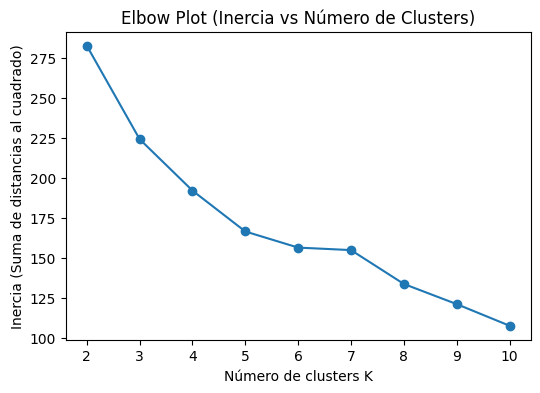

In [12]:
plt.figure(figsize=(6,4))
plt.plot(list(k_range), inertias, marker='o')
plt.xticks(k_range)
plt.title('Elbow Plot (Inercia vs Número de Clusters)')
plt.xlabel('Número de clusters K')
plt.ylabel('Inercia (Suma de distancias al cuadrado)')
plt.show()

Como podía suceder, el método del codo no pudo brindar de forma contundente una elección de K sensible, pues la gráfica es más bien suave y no presenta ese ángulo o cambio en la curva de la inercia que uno intentaría buscar.


Por otro lado, gracias al score de la silueta, donde la interpretación y la busqueda del mejor K se reduce a encontrar la clusterización que maximice este score, encontramos que K=5 es una mejor opción. Apesar de notar que a partir de K=8 el score de la silueta vuelve a crecer y comienza a hacerse comparable con K=5, tampoco es preferible tomar un número de clusters tan grande porque puede llevar a clusters muy pequeños y agrupaciones atómicas, recordando que tenemos un conjunto de 50 datos y donde K=10 ó 9, nos llevaría a clusters de tamaño 5, que pueden ser muy pequeños.

In [13]:
sil_vals = silhouette_samples(X, labels)
mean_sil = np.mean(sil_vals)
print(f"\nMean silhouette score: {mean_sil:.3f}")


Mean silhouette score: 0.205


Otra forma de verificar esta clusterización aprovechando el poder el score de la silueta es calculando dicho score para cada uno de los puntos y su cluster asociado:


Para cada uno de los $n$ puntos y para cada uno de los 5 clusters, graficamos la distribución de su coeficiente de silueta individual. Recordemos que el coeficiente de silueta de un punto $i$ se define como

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i),\,b(i)\}},
$$

donde

* $a(i)$ es la distancia media entre $i$ y todos los demás puntos de su mismo cluster (cohesión interna),
* $b(i)$ es la menor distancia media de $i$ a los puntos de cualquier otro cluster (separación externa).

De esta forma, el score de la silueta no solo considera la "pertenencia del punto" al cluster asociado, si no la "separación del punto" a los demás clusters. Así, puntos en la frontera entre los clusters o clusters "mezclados" son penalizados pues su cohesión interna es baja y podrían incluso no estar tan separados esos puntos de un cluster ajeno.

En la gráfica cada banda horizontal coloreada representa los valores $s(i)$ de todos los puntos pertenecientes a un mismo cluster, ordenados de menor a mayor a lo largo del eje vertical. La **anchura** de la banda en el eje $x$ es el valor de silueta: cuanto más se extienda hacia la derecha (hasta 1), mejor definido está ese punto dentro de su cluster. Valores cercanos a 0 indican que el punto está “en la frontera” entre dos clusters, y valores negativos (a la izquierda de cero) señalan que el punto podría haber estado mejor asignado a otro grupo.

Al visualizar todas las bandas juntas, podemos ver cuáles clusters presentan en general valores de silueta altos (bandas anchas y claras hacia la derecha) y cuáles tienen muchos puntos problemáticos. Un cluster con una banda muy estrecha o con partes oscuras (valores bajos o negativos) indica baja cohesión interna o solapamiento con otros grupos.


La línea vertical roja marca la el promedio del score de la silueta de todo el conjunto de datos. Es un umbral visual: idealmente, la mayoría de las bandas deberían quedar a la derecha de esta línea. Si se observan muchas barras cortas o negativas a la izquierda, el valor medio estará bajando, y probablemente ese $K$ no sea ideal. Cuanto más alta sea la media, más claramente separados y cohesionados están los clusters.

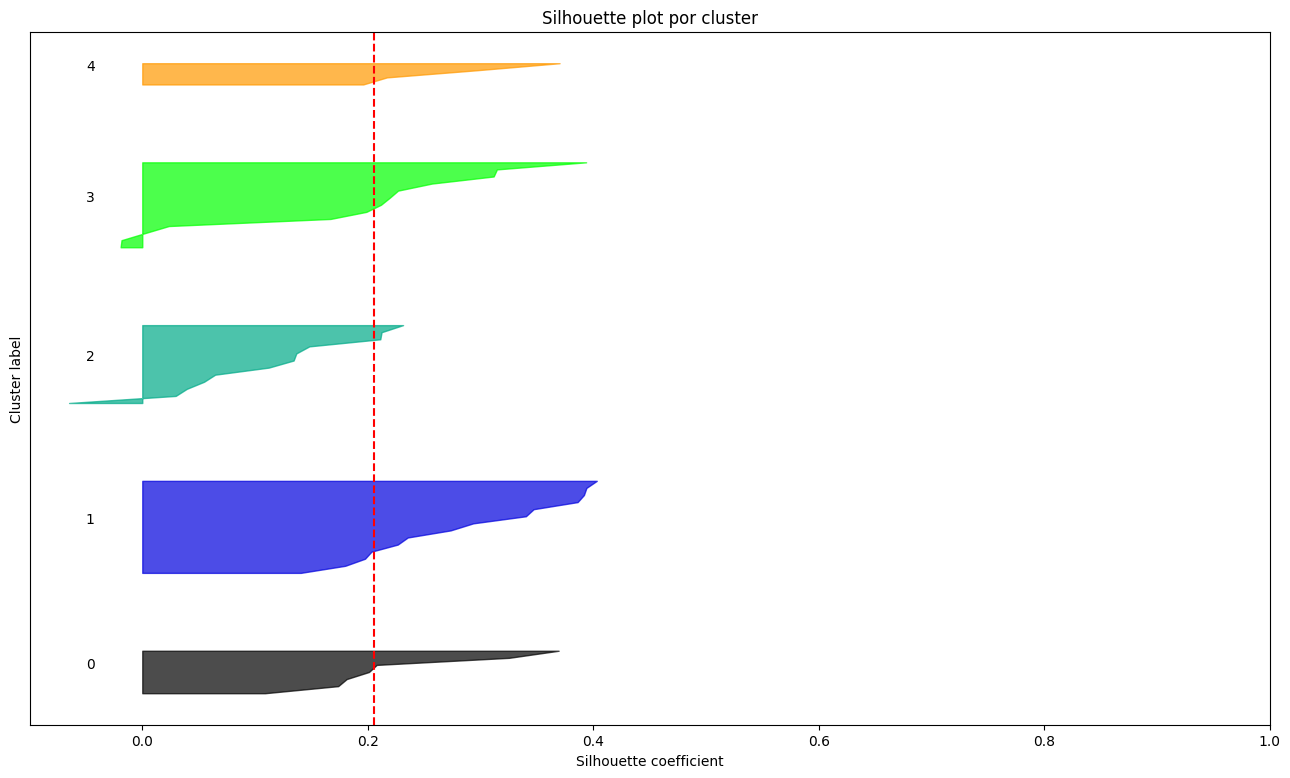

In [14]:
n_clusters = 5
fig, ax = plt.subplots(figsize=(16, 9))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_sil_vals = sil_vals[labels == i]
    ith_cluster_sil_vals.sort()
    size_cluster_i = ith_cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_sil_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # etiqueta del cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # espacio entre clusters

ax.set_title("Silhouette plot por cluster")
ax.set_xlabel("Silhouette coefficient")
ax.set_ylabel("Cluster label")

ax.axvline(x=mean_sil, color="red", linestyle="--")
ax.set_yticks([])  # no mostramos ticks en y
ax.set_xlim([-0.1, 1])
plt.show()

   Con esta información y considerando que:

   * **Puntos con $s(i)\approx1$**: son muy bien asignados, lejos de otros clusters.
   * **Puntos con $s(i)\approx0$**: están en la frontera; su asignación es ambigua.
   * **Puntos con $s(i)<0$**: están mal asignados; pertenecerían conceptualmente a otro cluster.

   Nos indica que el algoritmo de KMeans con este tratamiento de datos logra separar muy bien al conjunto de jugadores, y que solamente presenta problemas el modelo para distinguir o clasificar jugadores que están en el cluster 2 y 3, pero son una minoría, reflejando el buen desempeño global del modelo.

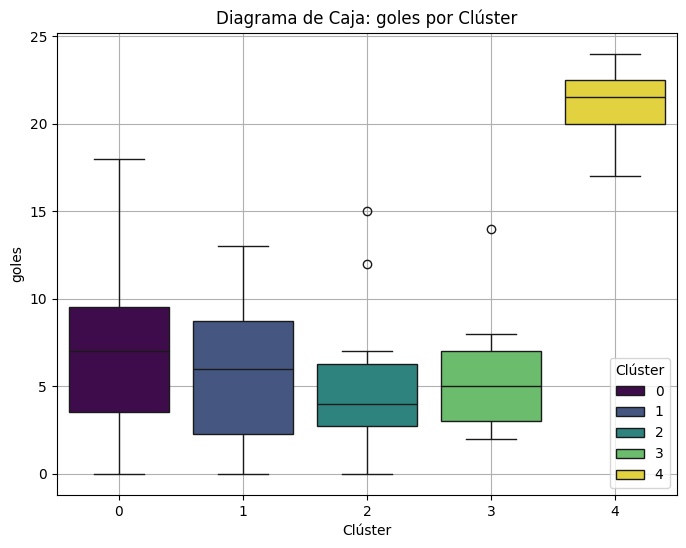

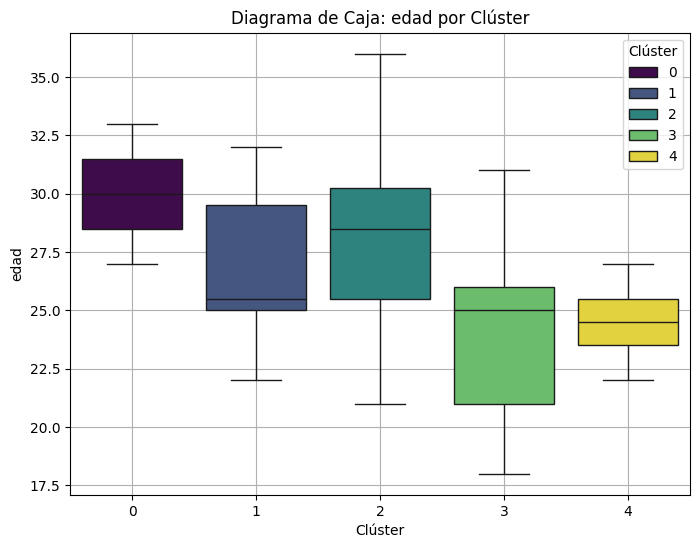

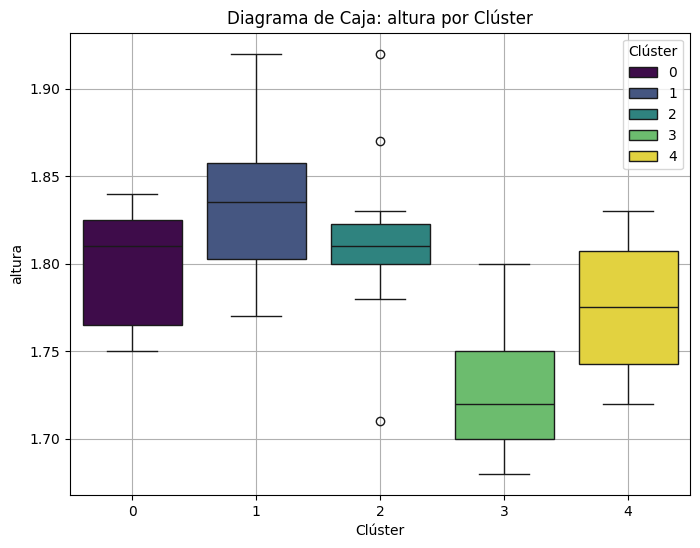

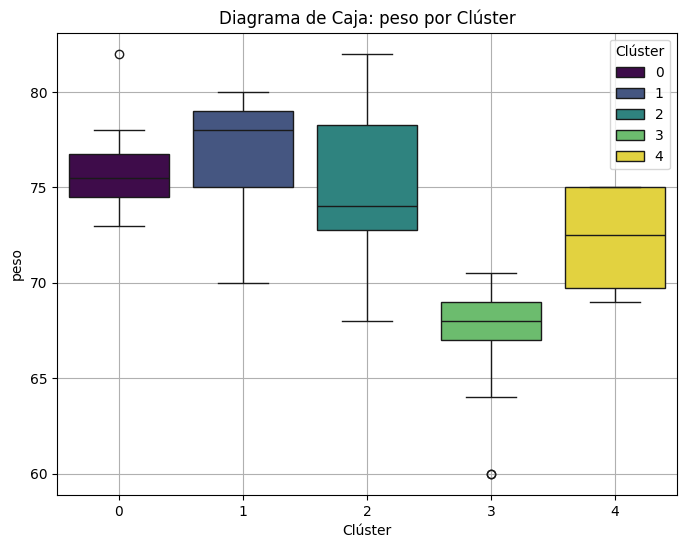

In [15]:
vars = ["goles", "edad", "altura", "peso"]
df["cluster"] = labels
# Crear diagramas de caja para cada variable
for var in vars:
 plt.figure(figsize=(8, 6))
 sns.boxplot(data=df, x="cluster", y=var, hue="cluster", palette="viridis")
 plt.title(f"Diagrama de Caja: {var} por Clúster")
 plt.xlabel("Clúster")
 plt.ylabel(var)
 plt.grid(True)
 plt.legend(title="Clúster")
 plt.show()

## Conclusiones

Se realizó un análisis de clustering utilizando varias técnicas como K-means y clustering jerárquico. Según el dendrograma, encontré entre 2 a 3 clusters, lo que coincidió con la elección de k=5 al usar el método de la silueta. También observé las diferencias entre los centros de los clusters, lo que reveló variaciones significativas en características como la edad, nacionalidad y educación. Además, utilicé boxplots para comparar las variables en cada grupo, identificando patrones como un grupo de estudiantes con mejores puntajes en el objetivo.

Se comenzó calculando la matriz de distancias de Gower sobre las siete variables de los 50 jugadores —mezclando goles, edad, altura, peso, pierna dominante, nacionalidad y estudios— para capturar de manera homogénea tanto la información numérica como la categórica. Al aplicar clustering jerárquico con enlace simple, el dendrograma mostró fusiones tempranas de ciertos subgrupos muy parecidos (por ejemplo algunos jugadores con misma nacionalidad y perfil físico), mientras que otros tardaban en agruparse (jugadores atípicos con combinaciones de edad avanzada y alto rendimiento goleador) . Este análisis inicial sugería que, pese a la aparente heterogeneidad, habría entre 2 y 3 grandes agrupaciones en la muestra, con algunos outliers que merecían atención.

Para afinar la partición, se transformaron los datos mediante pipelines —escalando numéricos, aplicando `OneHotEncoder` a “nacionalidad”, `OrdinalEncoder` a “estudios” y un simple `FunctionTransformer` a “pierna”— y pasé un KMeans para $K=2\ldots10$. El **elbow plot** resultante fue muy suave, difícil de interpretar; en cambio el **silhouette score** alcanzó su valor máximo en $K=5$, lo que indica la mejor relación entre cohesión interna y separación externa de clusters. Al inspeccionar los centros estandarizados de cada uno de los 5 grupos, identifiqué un clúster de goleadores promedios muy altos y menor edad, otro de jugadores muy altos y pesados con bajo rendimiento goleador, y varios segmentos intermedios (por ejemplo perfiles balanceados con estudios superiores o pierna izquierda) que confirman cómo distintas combinaciones de variables físicas y formativas explican la heterogeneidad de los jugadores.
